# Object Detection For Drones Using YOLOV5 on VisDrone2019 Dataset

##### - *Siddhartha Reddy Lingala Bayanna 200968016*

### In this noteboook, we train YOLOV5 model on the training data.
### ultralytics/yolov5 github repo is used for training and prediction.

#### Cloning the repo and building the environment

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 14465, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 14465 (delta 12), reused 18 (delta 8), pack-reused 14430
Receiving objects: 100% (14465/14465), 13.48 MiB | 23.96 MiB/s, done.
Resolving deltas: 100% (9994/9994), done.


Installing the req packages

In [ ]:
pip install -r yolov5/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 14.8 MB/s 


In [ ]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

Testing the annotations

In [ ]:
Image.open("/content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-val/images/0000001_02999_d_0000005.jpg")

Loading class & label data

In [ ]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"Ignore":0,
                            "Pedestrian":1,
                            "People":2,
                            "Bicycle":3,
                            "Car":4,
                            "Van":5,
                            "Truck":6,
                            "Tricycle":7,
                            "Awning-tricycle":8,
                            "Bus":9,
                            "Motor":10,
                            "Others":11
                           }

In [ ]:
val_labels= [os.path.join('/content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-val/labels', x) for x in os.listdir('/content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-val/labels') if x[-3:] == "txt"]
len(val_labels)

548

/content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-val/labels/0000271_03001_d_0000387.txt
/content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-val/images/0000271_03001_d_0000387.jpg


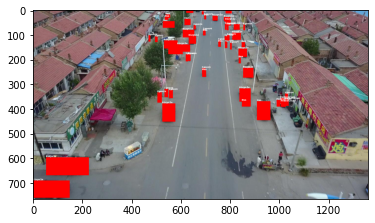

In [ ]:
# random.seed(0)
class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)),(255, 0, 0))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(val_labels)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]


print(annotation_file)

#Get the corresponding image file
image_file = annotation_file.replace("labels", "images").replace("txt", "jpg")

print(image_file)

assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

as we can see the labels map the objects correctly in the image.The converting into the requried format is succesful!!.

Hyperparameter Config File

In [ ]:
lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.2  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4  # image HSV-Value augmentation (fraction)
degrees: 0.0  # image rotation (+/- deg)
translate: 0.1  # image translation (+/- fraction)
scale: 0.5  # image scale (+/- gain)
shear: 0.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.0  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 1.0  # image mosaic (probability)
mixup: 0.0  # image mixup (probability)

Custom Network Architecture

In [ ]:
# parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]




## Training the model

In [ ]:
cd yolov5

/content/yolov5


In [ ]:
!python train.py --img 1080 --cfg yolov5n.yaml --hyp hyp.scratch-low.yaml --batch 32 --epochs 15 --data visdrone.yaml --weights yolov5n.pt --workers 24 --name yolon_visdrone_det

train: weights=yolov5n.pt, cfg=yolov5n.yaml, data=visdrone.yaml, hyp=hyp.scratch-low.yaml, epochs=15, batch_size=32, imgsz=1080, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=runs/train, name=yolon_visdrone_det, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-213-gbe9ef38 Python-3.7.15 torch-1.12.1+cu113 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, deg

In [ ]:
 !python train.py --img 720 --cfg yolov5n.yaml --hyp hyp.scratch-low.yaml --batch 32 --epochs 10 --data visdrone.yaml --weights yolov5n.pt

train: weights=yolov5n.pt, cfg=yolov5n.yaml, data=visdrone.yaml, hyp=hyp.scratch-low.yaml, epochs=10, batch_size=32, imgsz=720, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-215-g575055c Python-3.7.15 torch-1.12.1+cu113 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, transla

Detecting the labels:

  using the model saved after the latest epoch

In [ ]:
!python detect.py --source /content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-test-dev/VisDrone-test-dev/images --weights yolov5l6.pt --conf 0.25 --name yolov5l6

detect: weights=['yolov5l6.pt'], source=/content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-test-dev/VisDrone-test-dev/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolov5l6, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-216-g6e544d5 Python-3.7.15 torch-1.12.1+cu113 CPU

100% 147M/147M [00:20<00:00, 7.58MB/s]

Fusing layers... 
YOLOv5l6 summary: 476 layers, 76726332 parameters, 0 gradients
image 1/1610 /content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-test-dev/VisDrone-test-dev/images/0000006_00159_d_0000001.jpg: 384x640 21 cars, 7 trucks, 1551.5ms
image 2/1610 /content/drive/MyDrive/VisDrone2019-DET/VisDrone2019-DET-test-dev/VisDrone-test-dev/images/0000006_0

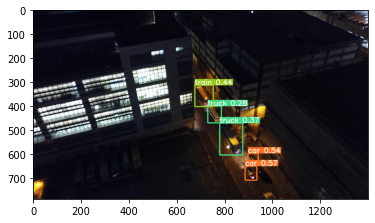

In [ ]:
detections_dir = "runs/detect/yolov5l6/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

After training the yolo model the weights are saved as yolo5l-xs-1 and yolo5l-xs-2

# Inference


In [ ]:
python val.py --weights ./weights/yolov5l-xs-1.pt --img 1996 --data ./data/VisDrone.yaml
                                    yolov5l-xs-2.pt
--augment --save-txt  --save-conf --task val --batch-size 8 --verbose --name v5l-xs

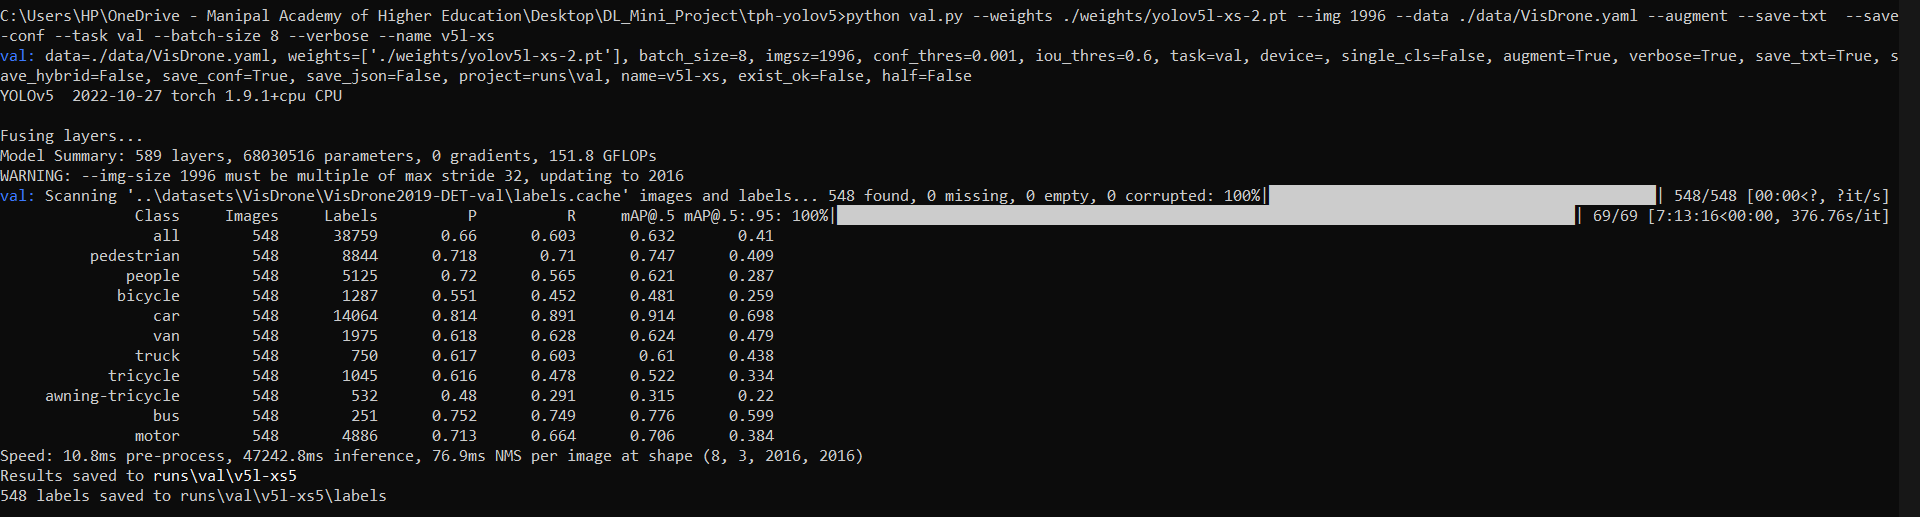

## running the inference on local sysytem ( colab ram has exceeded ) for 7hrs. The results are:

confusion matrix:

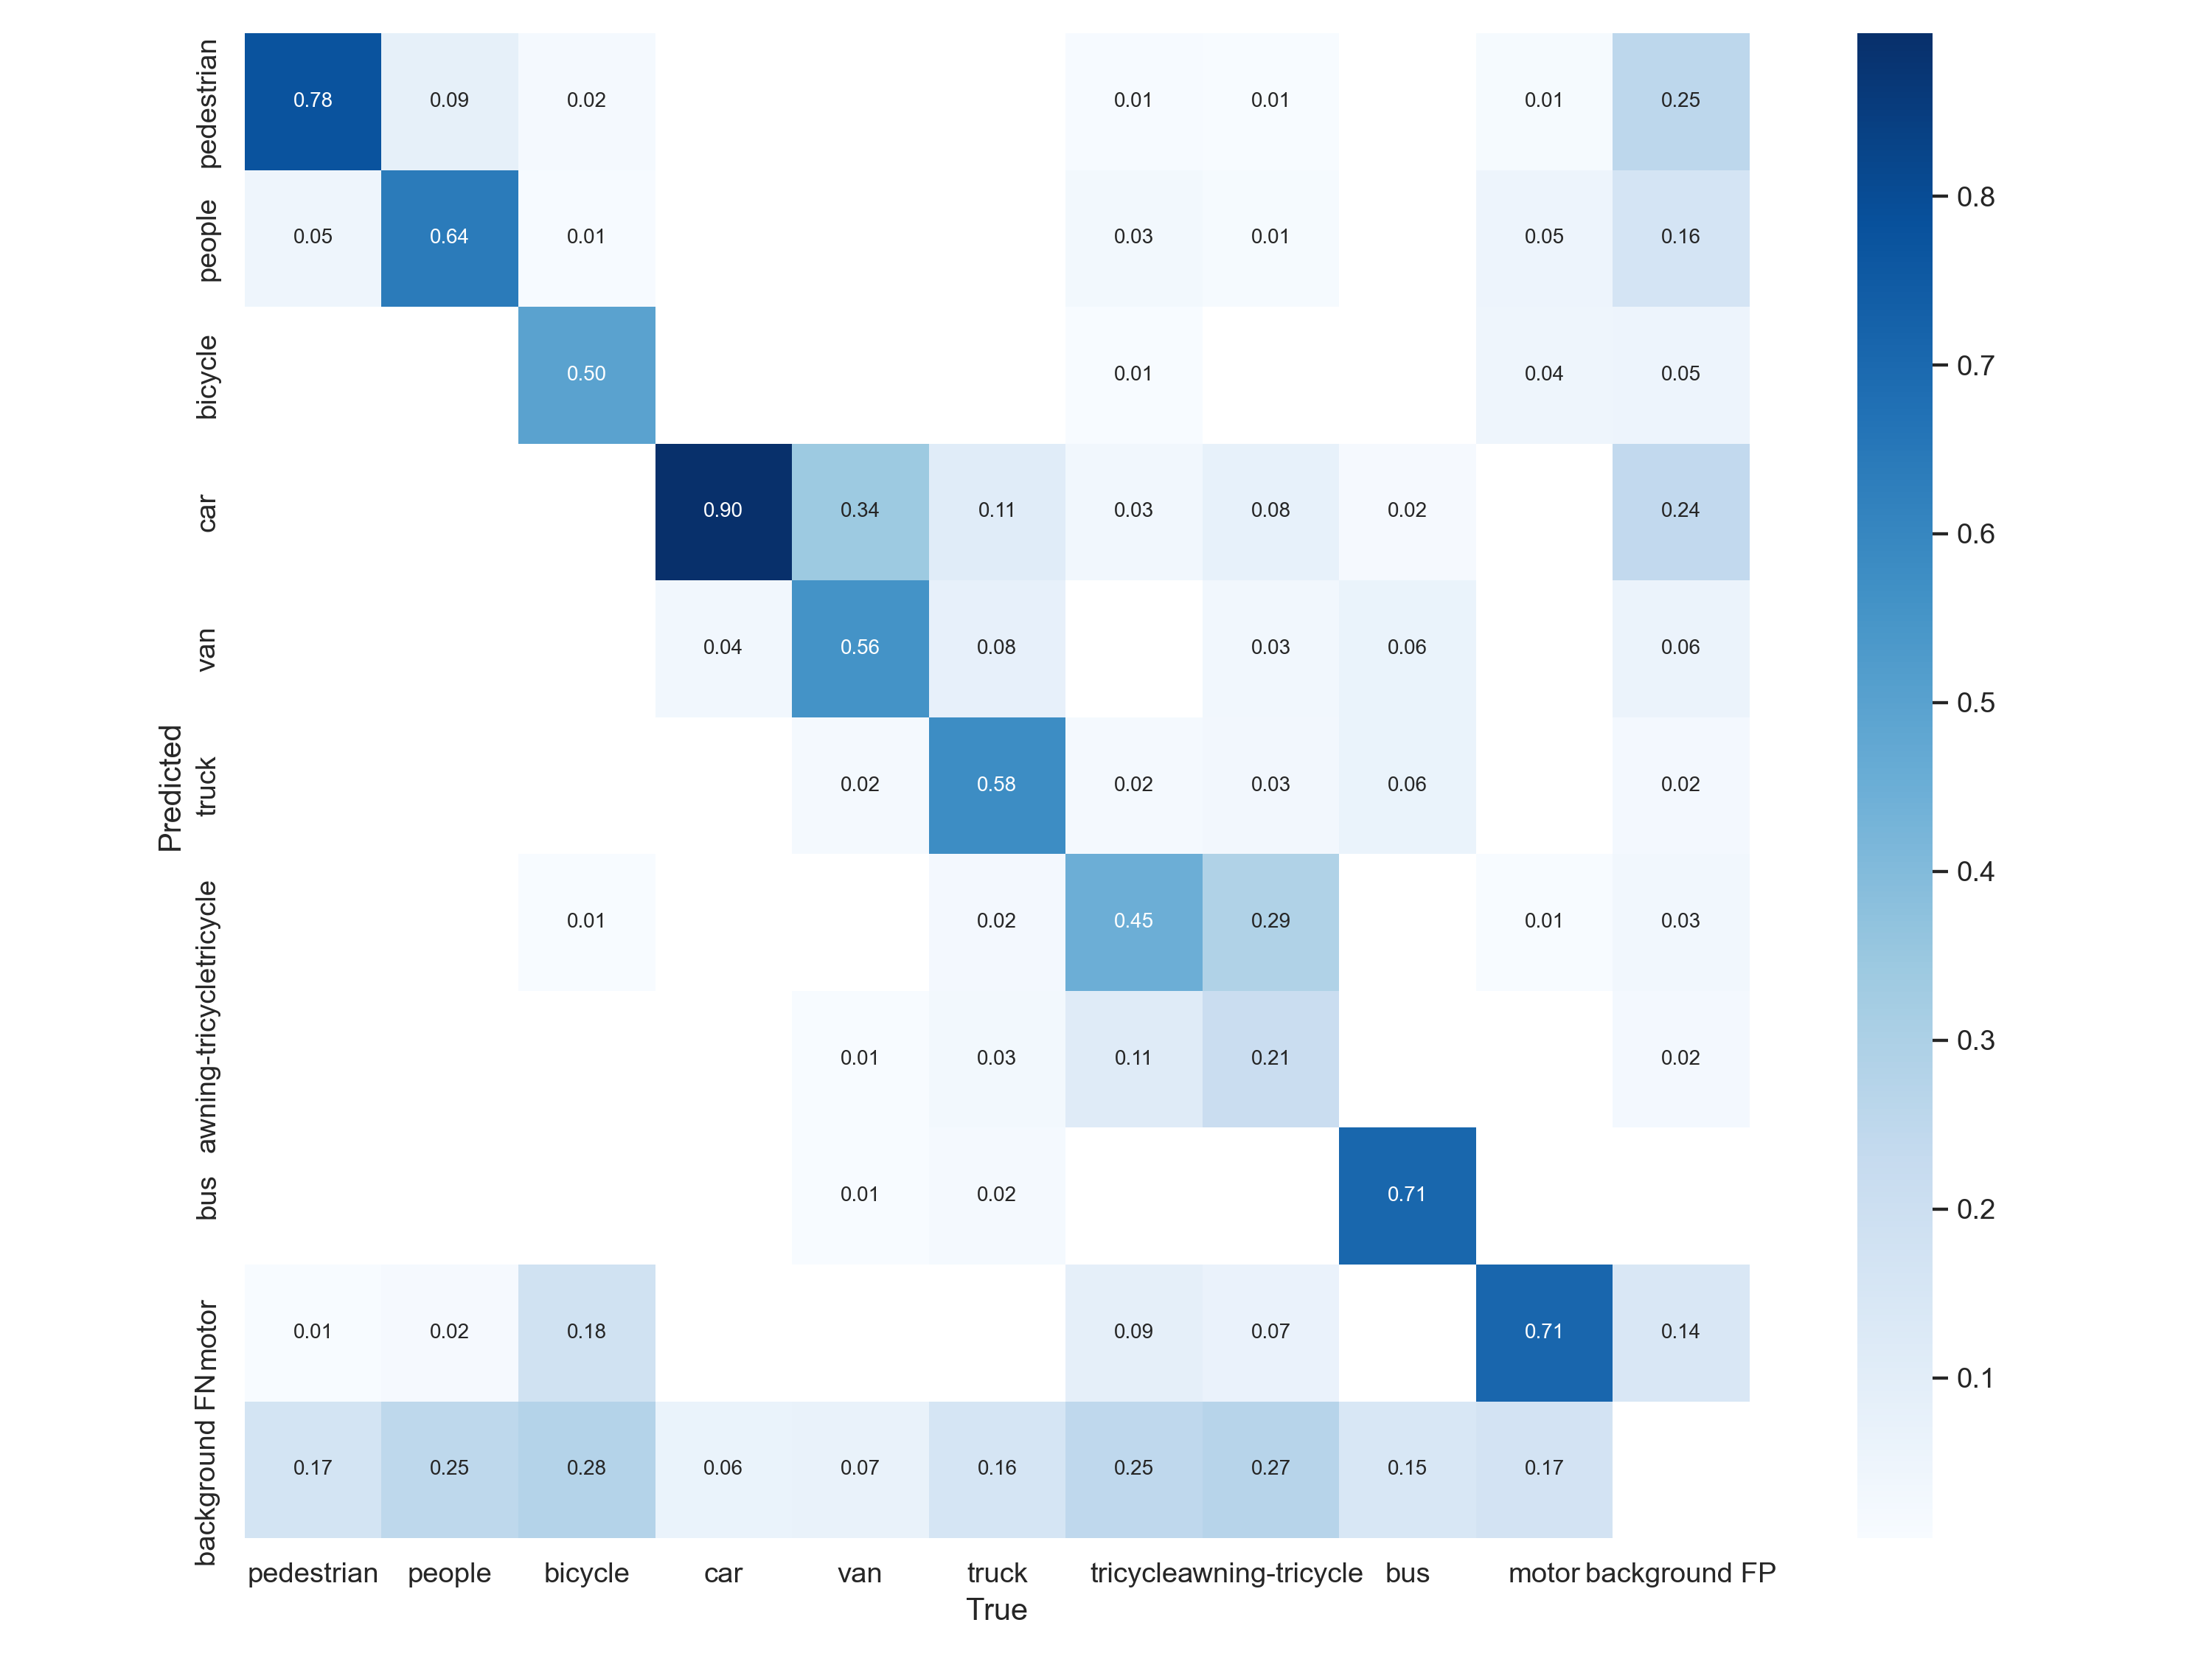

F1 curve:

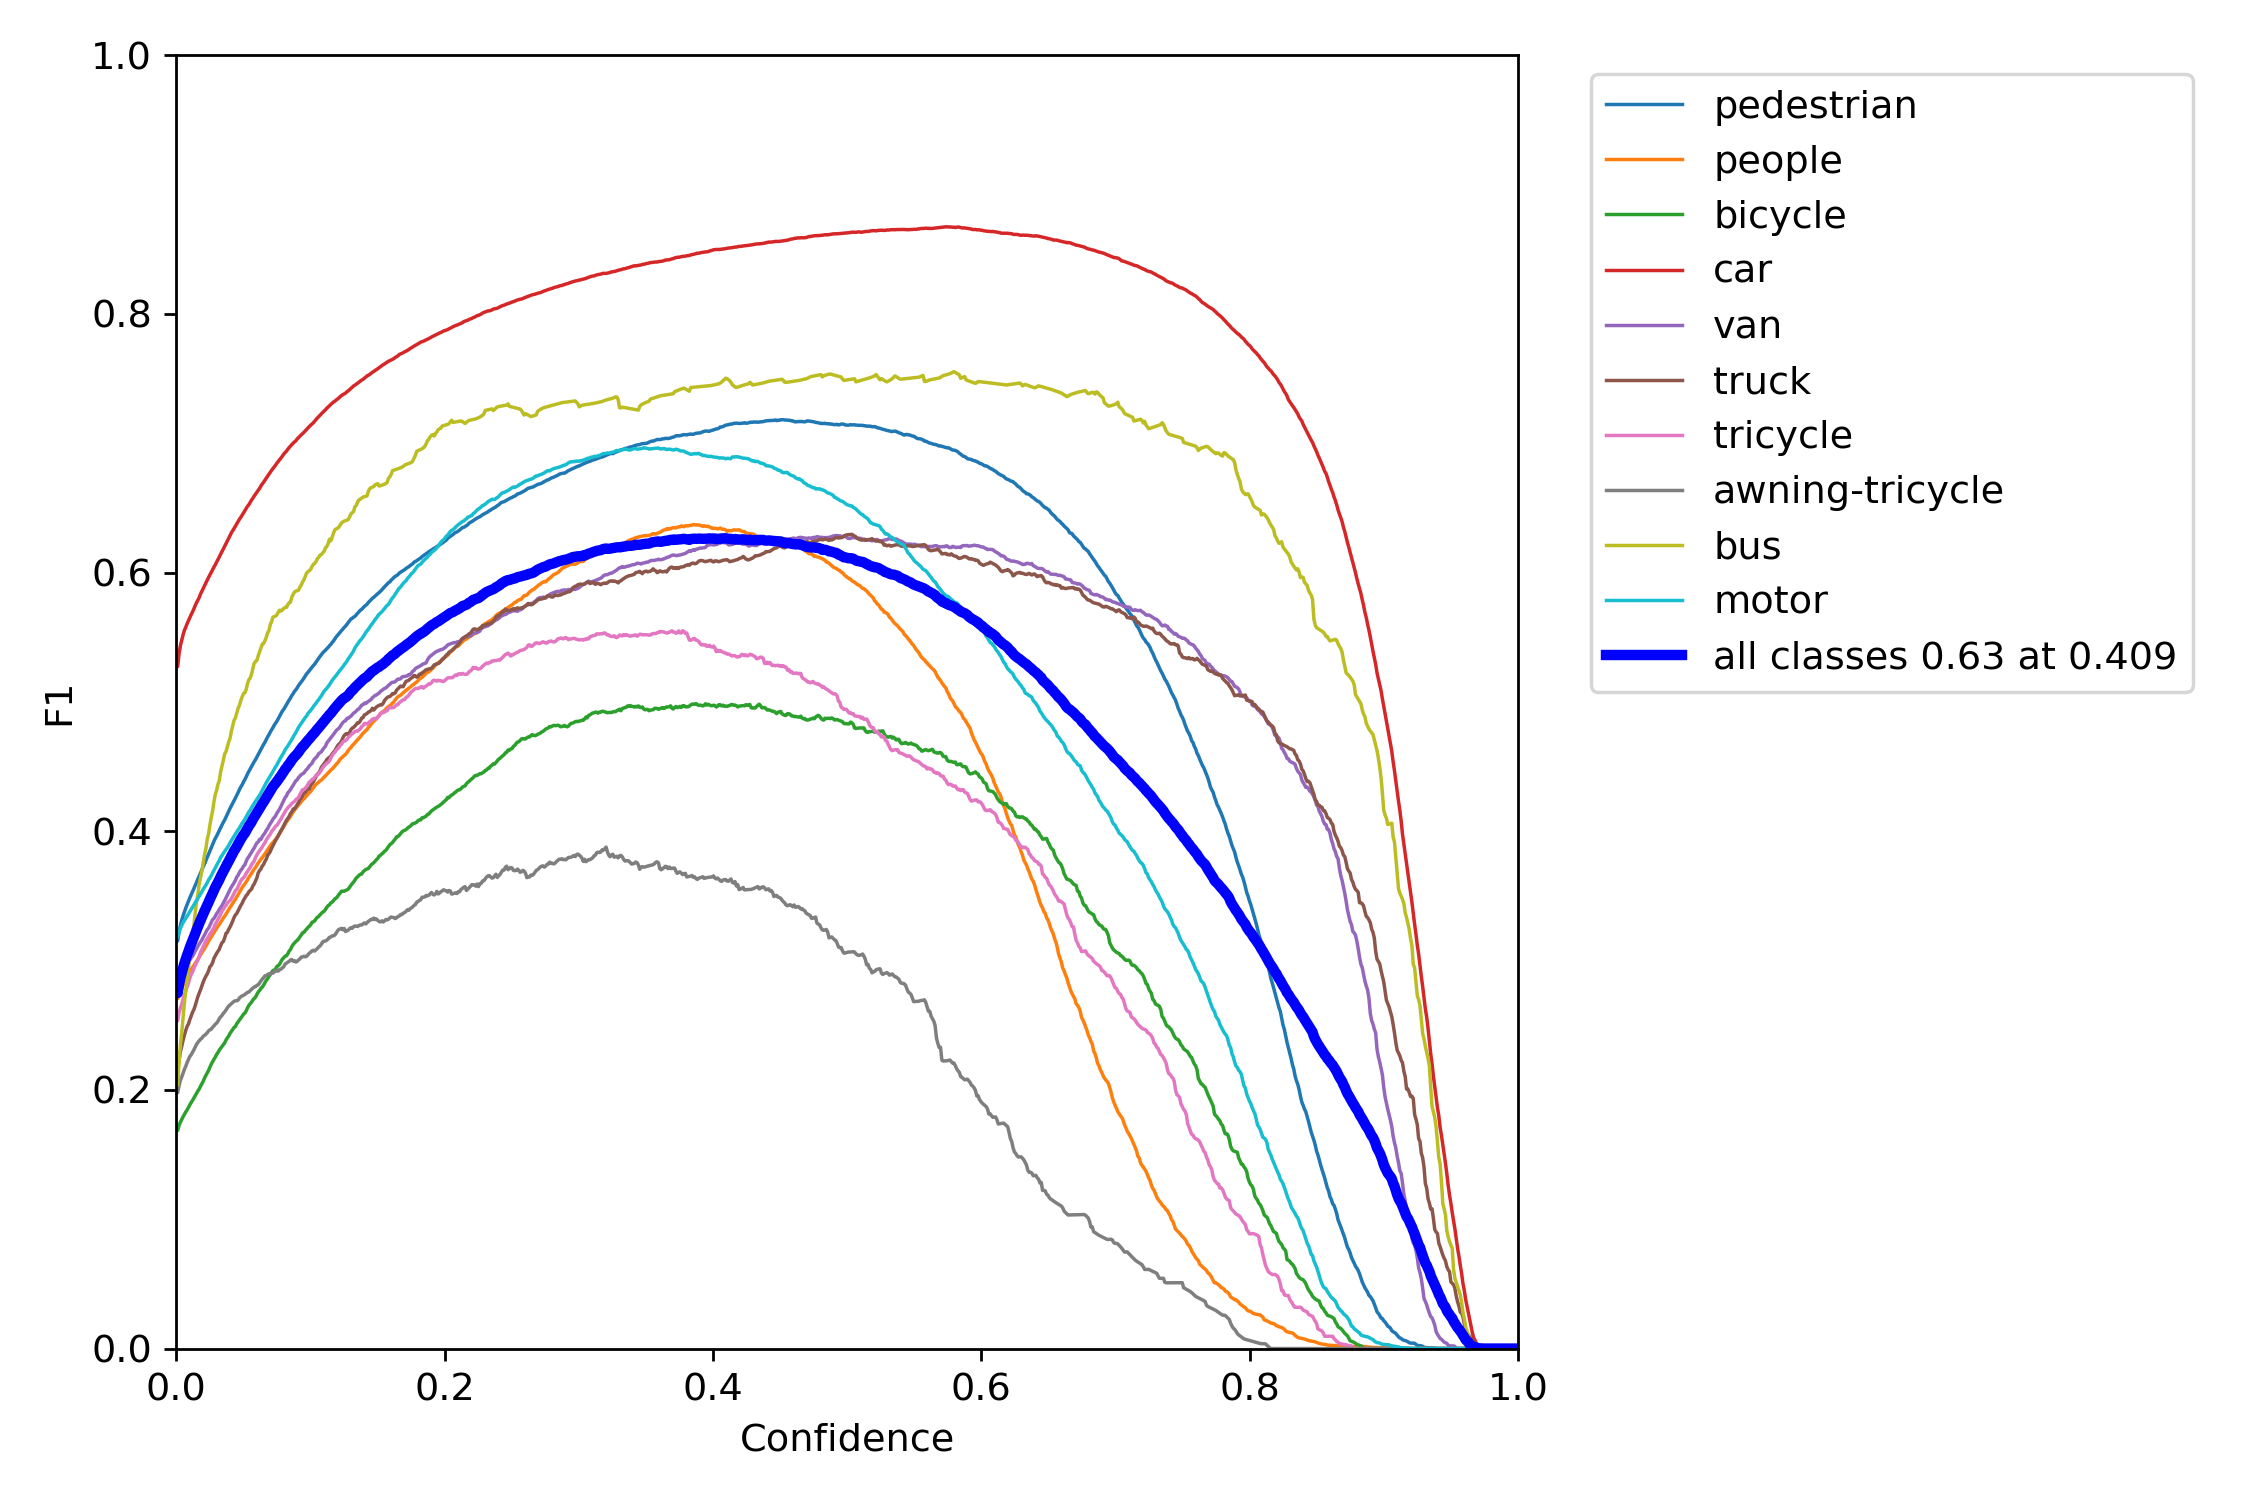

P_curve

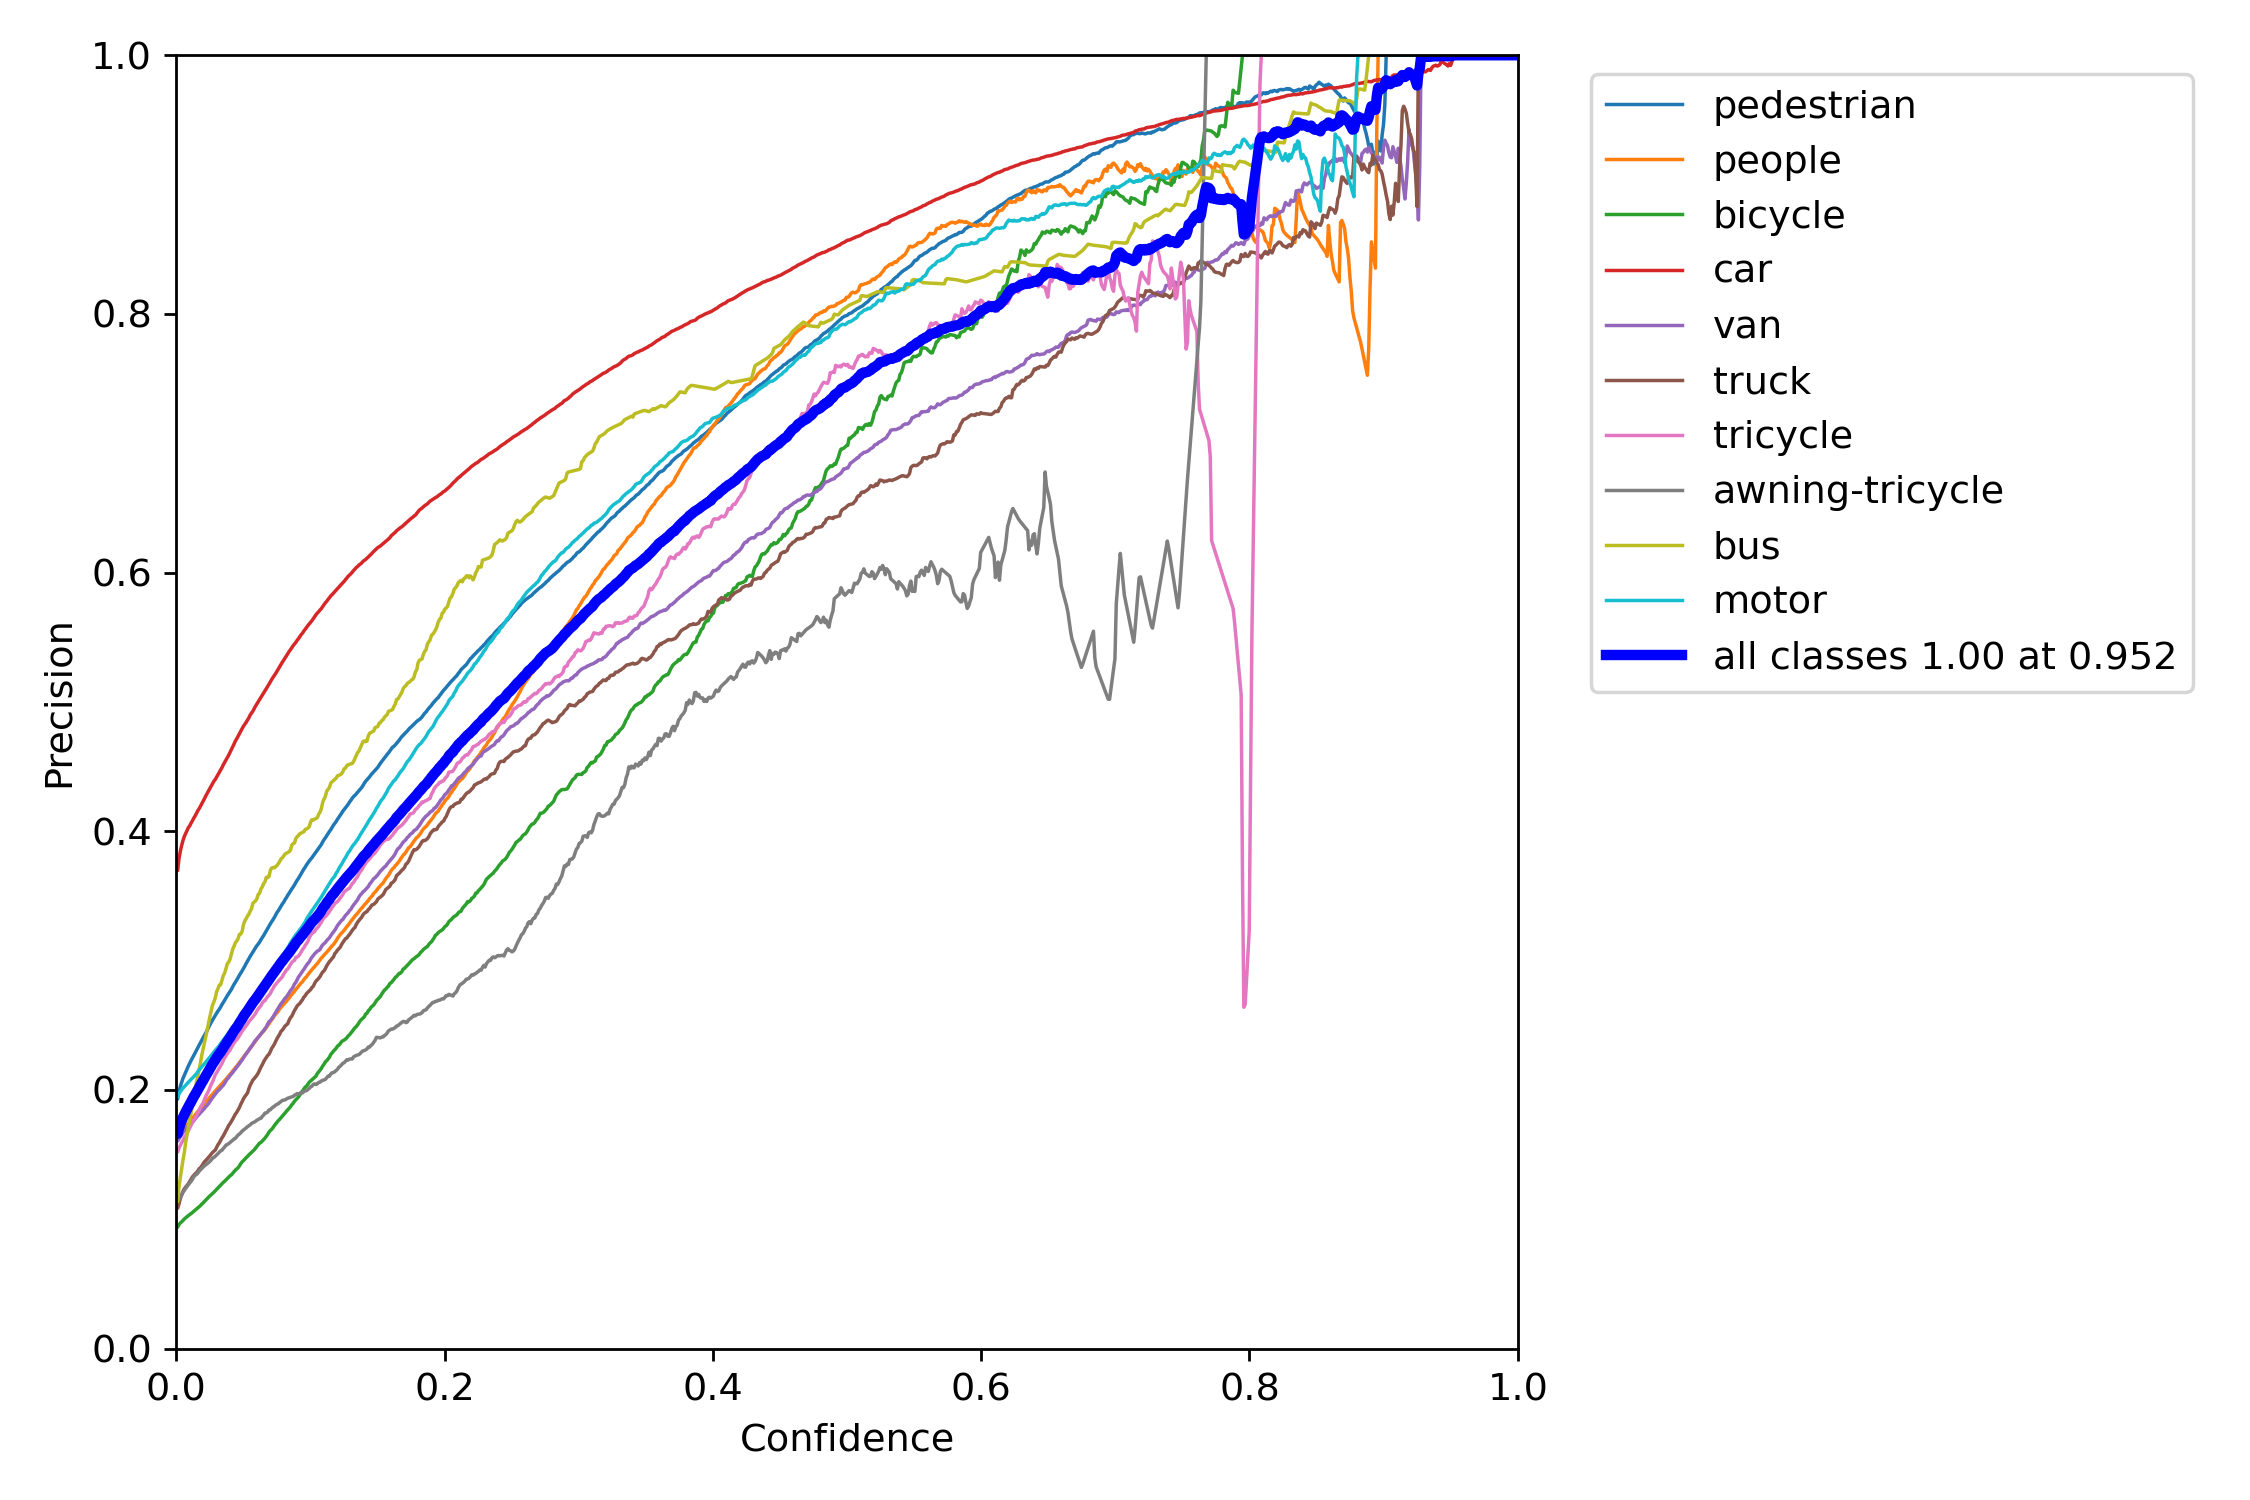

R_curve

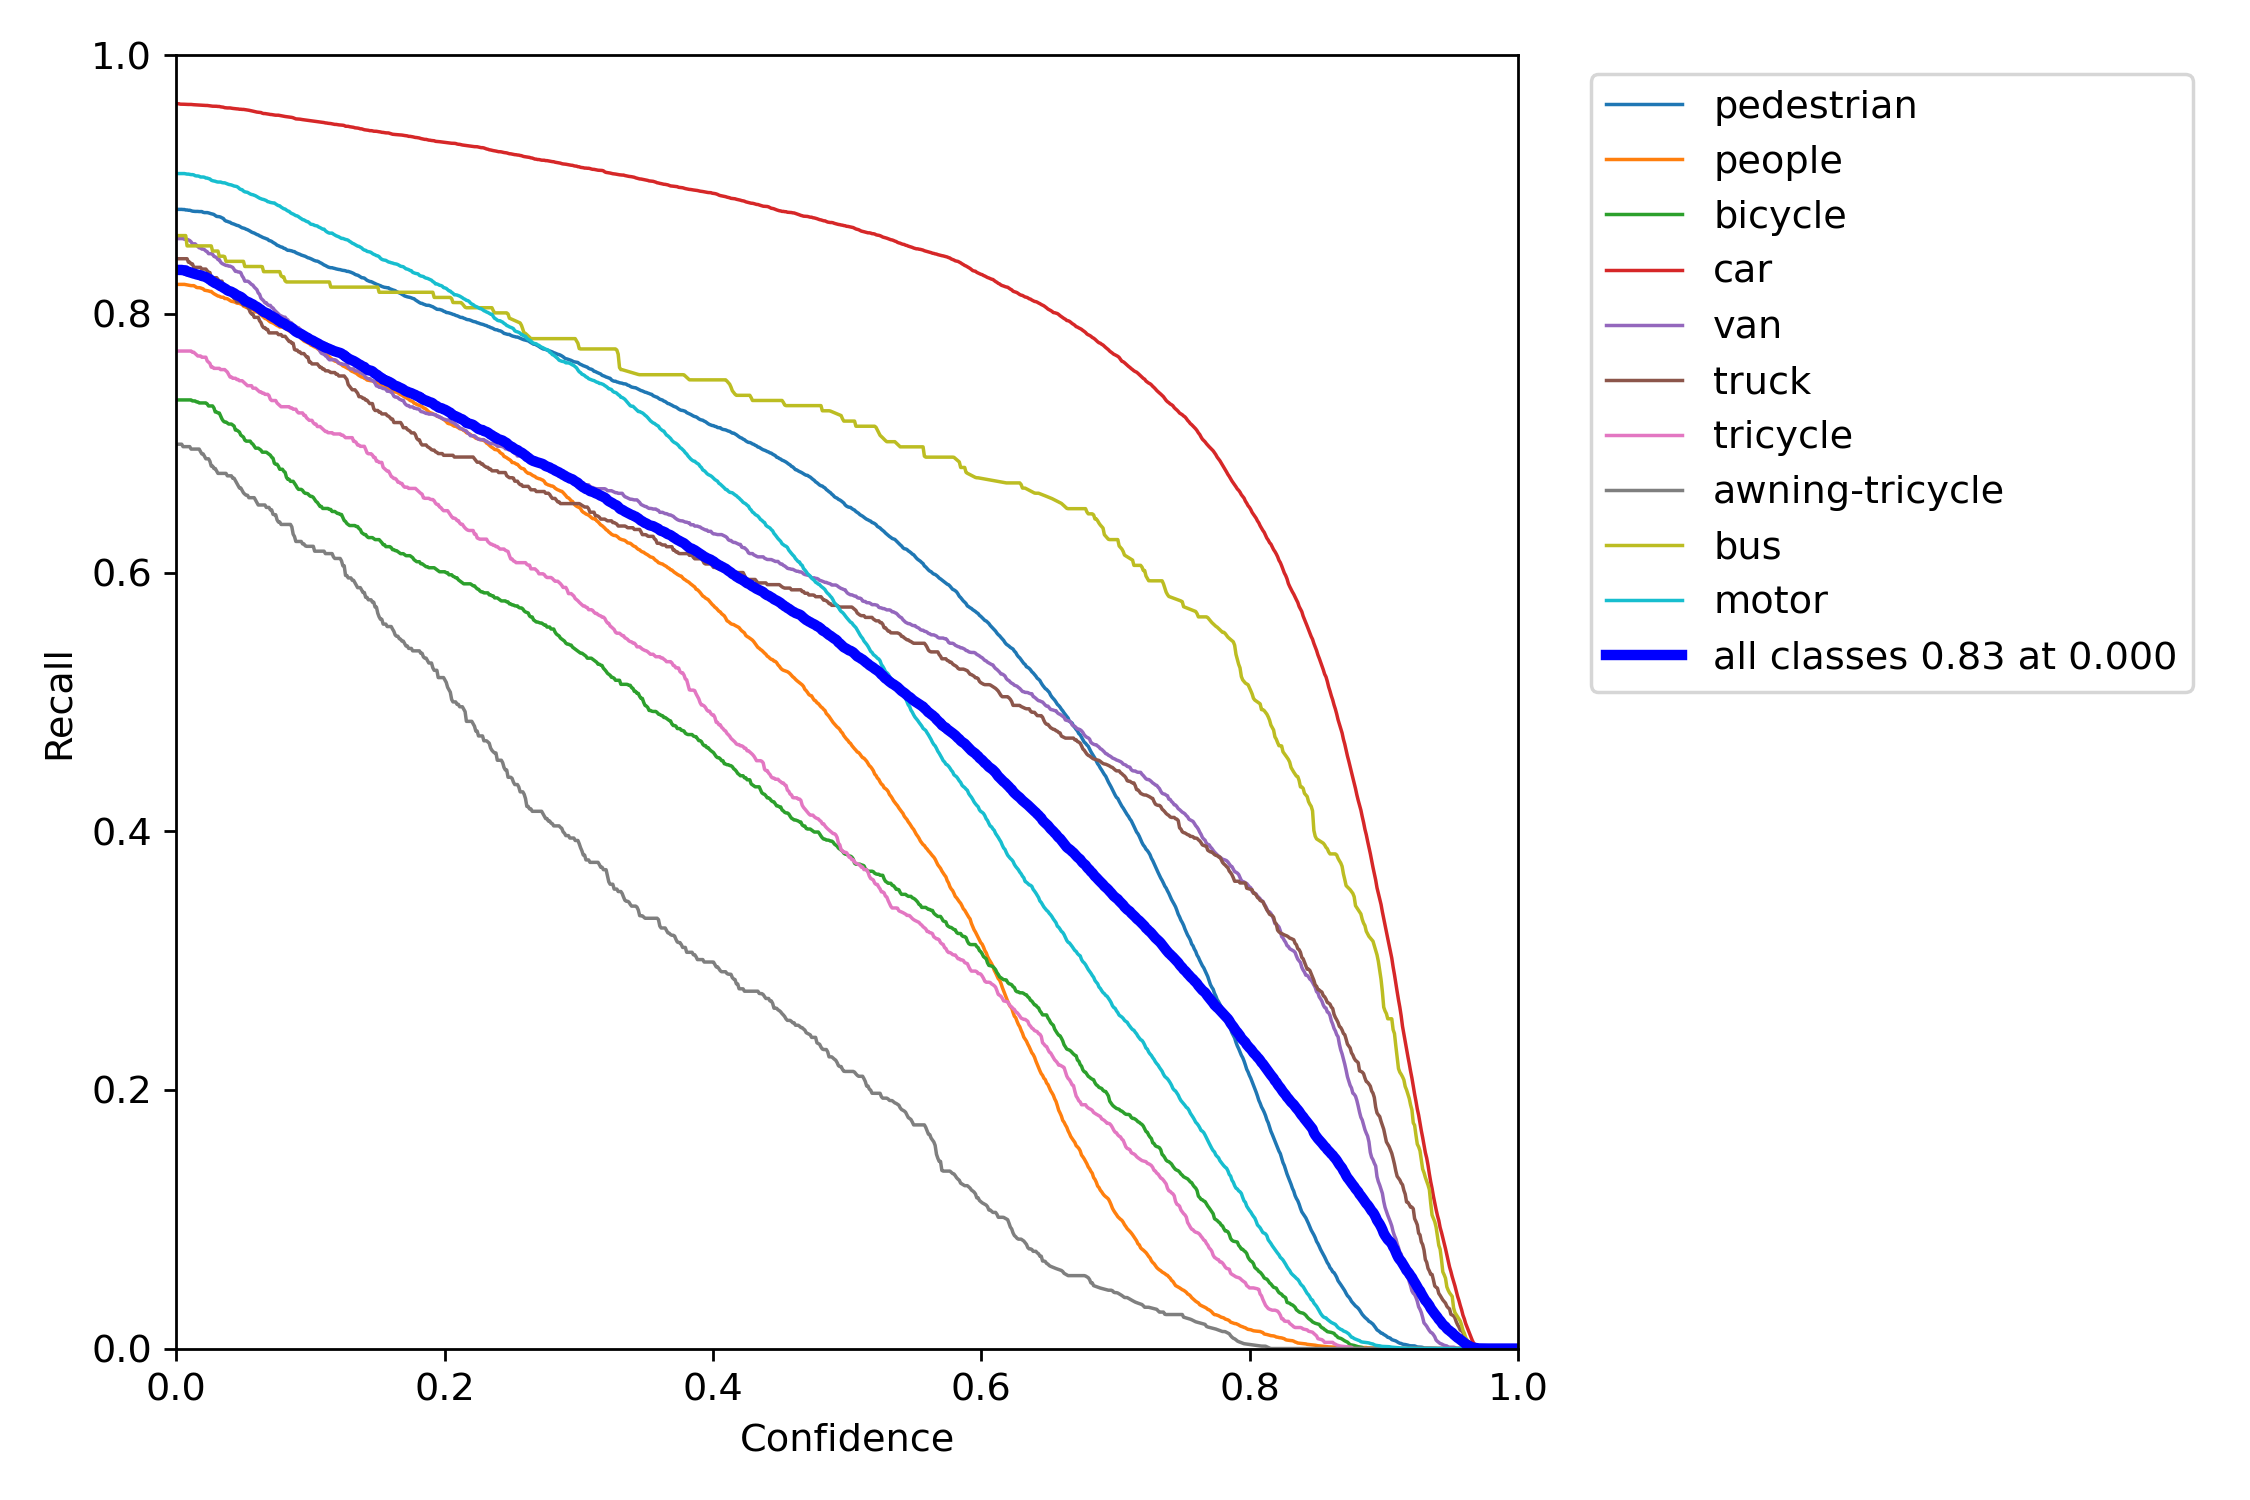

PR_curve

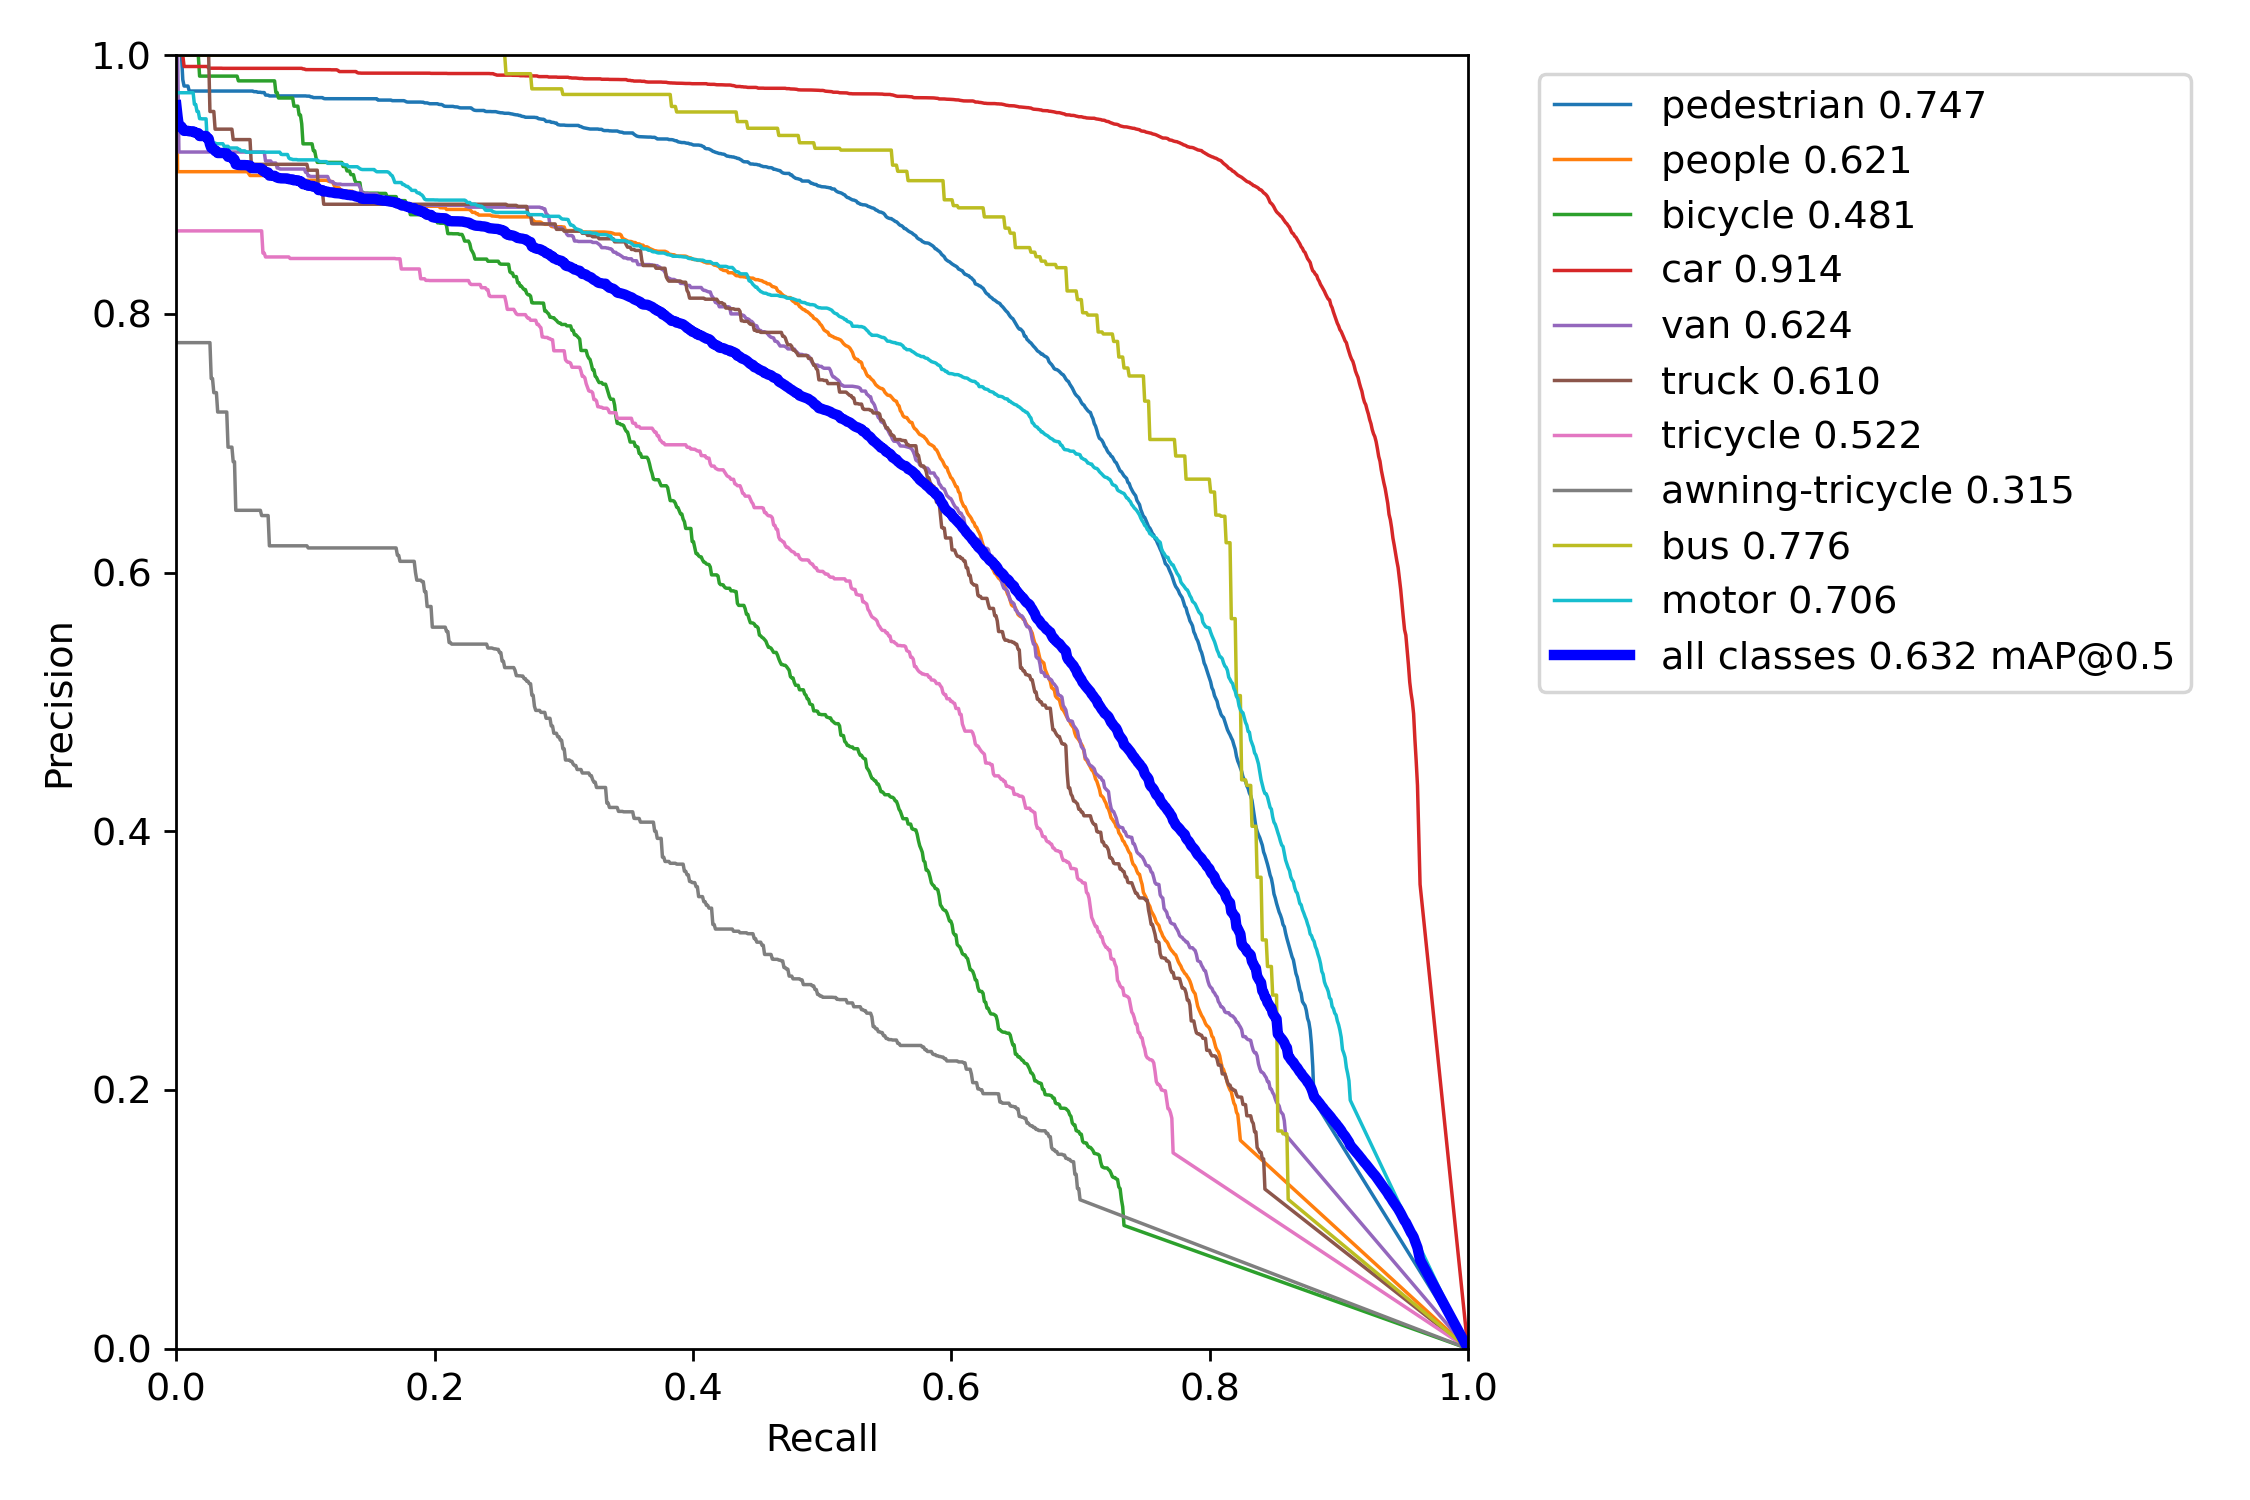

## Checking the predictions of the newly trained model and comparing with the actual annotations

labels:


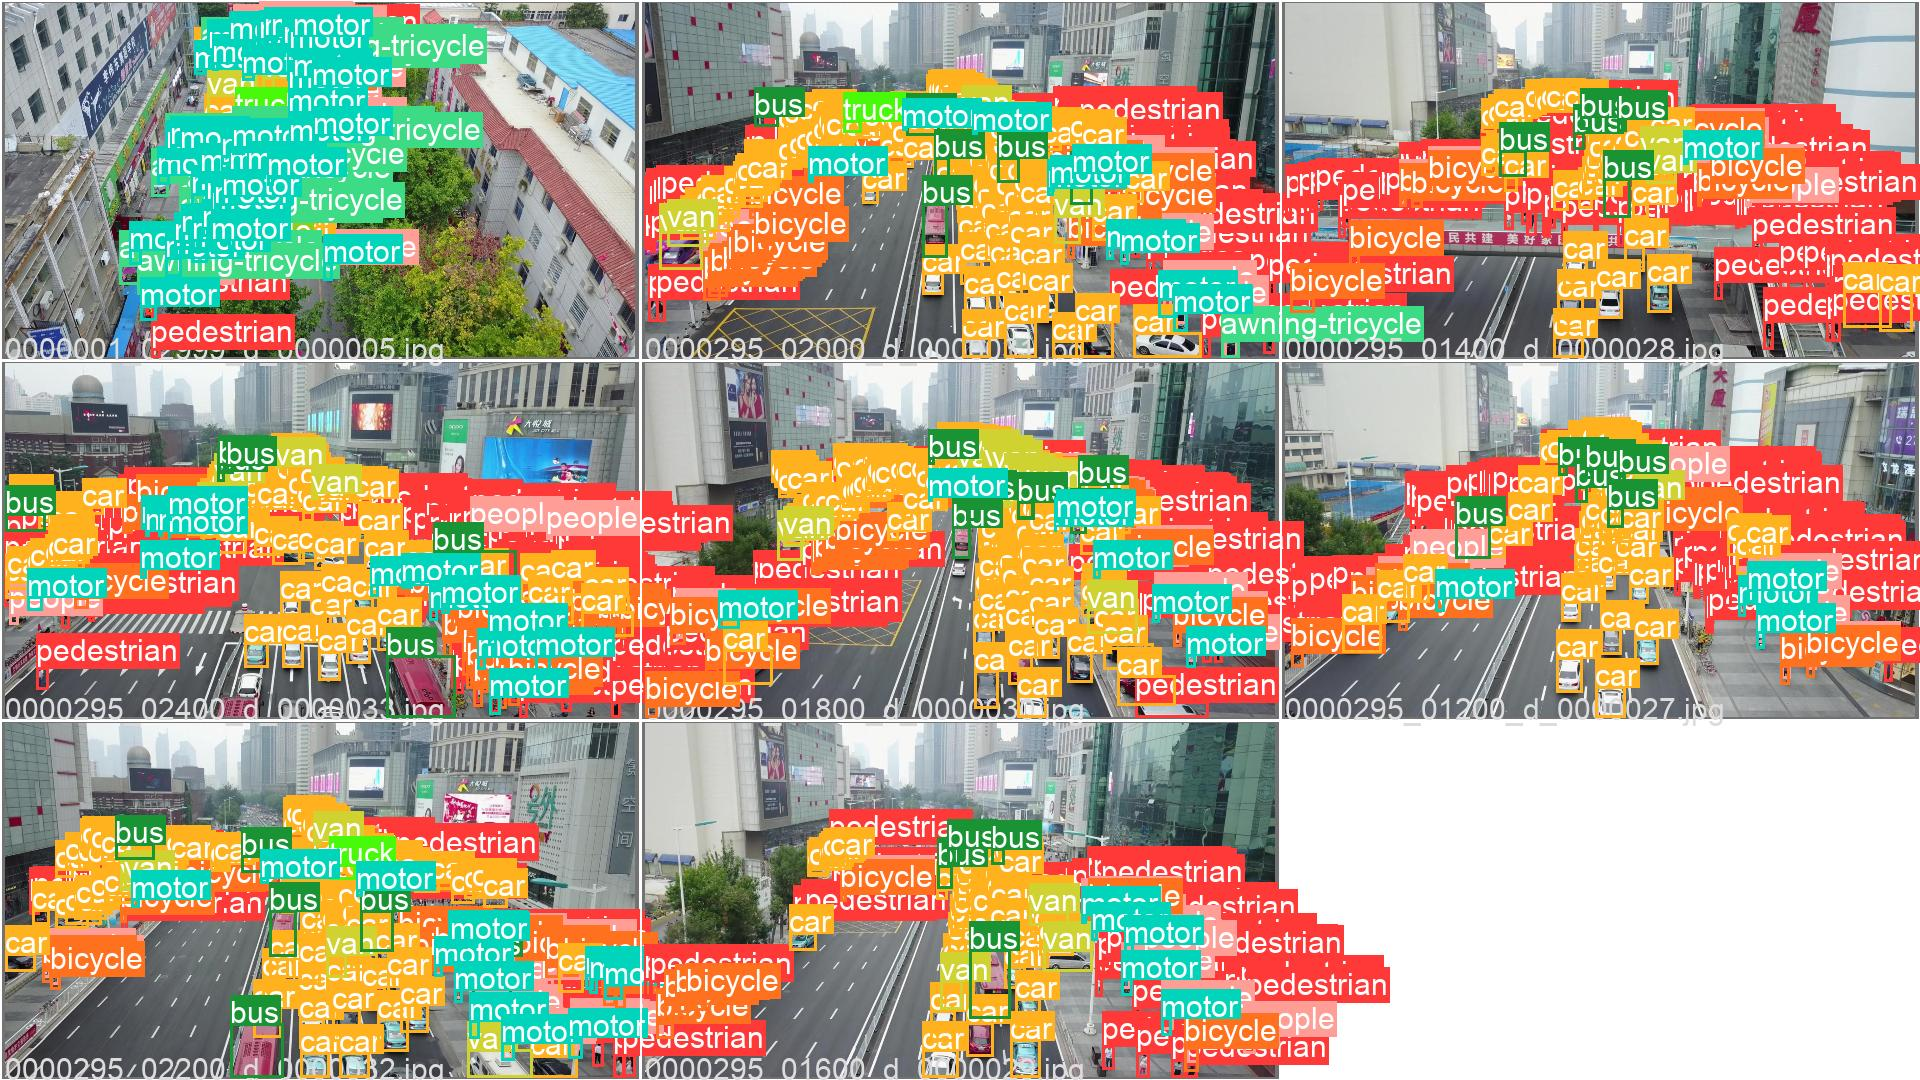

predictions:

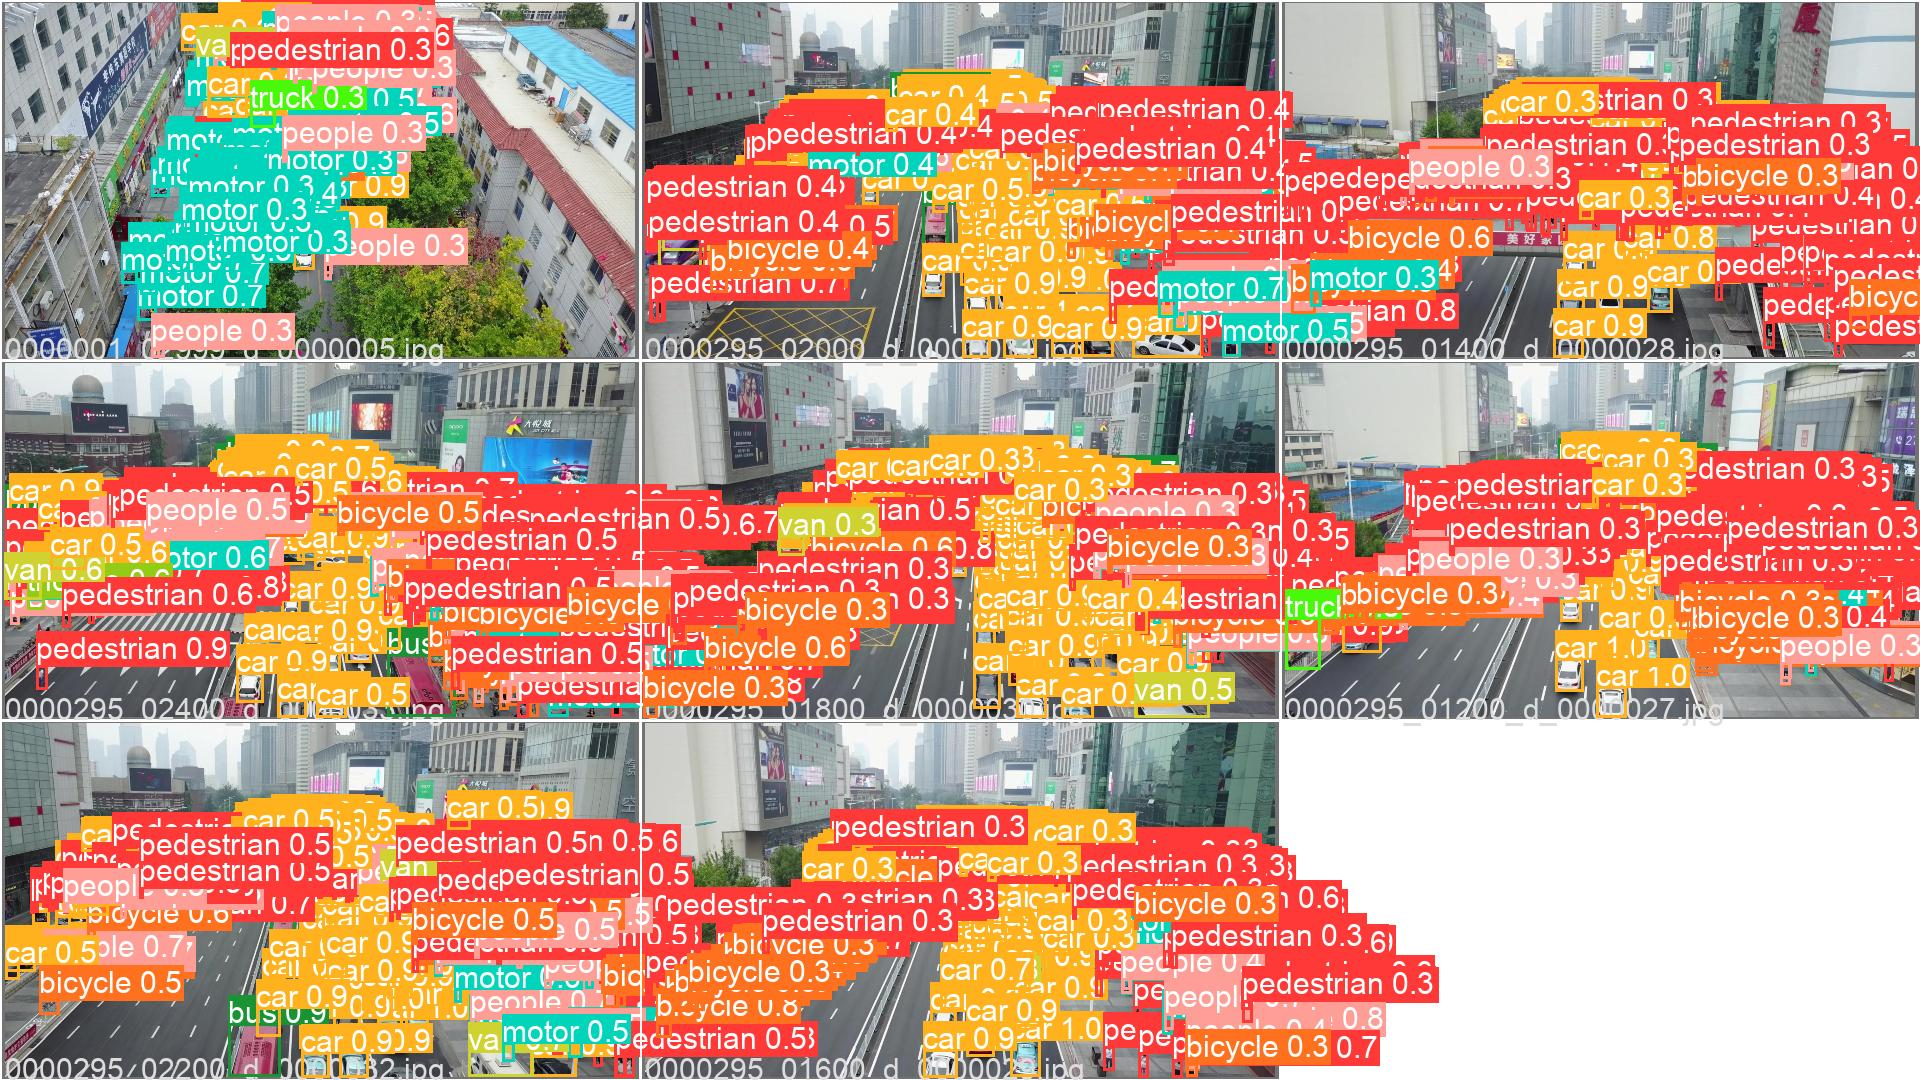

labels:

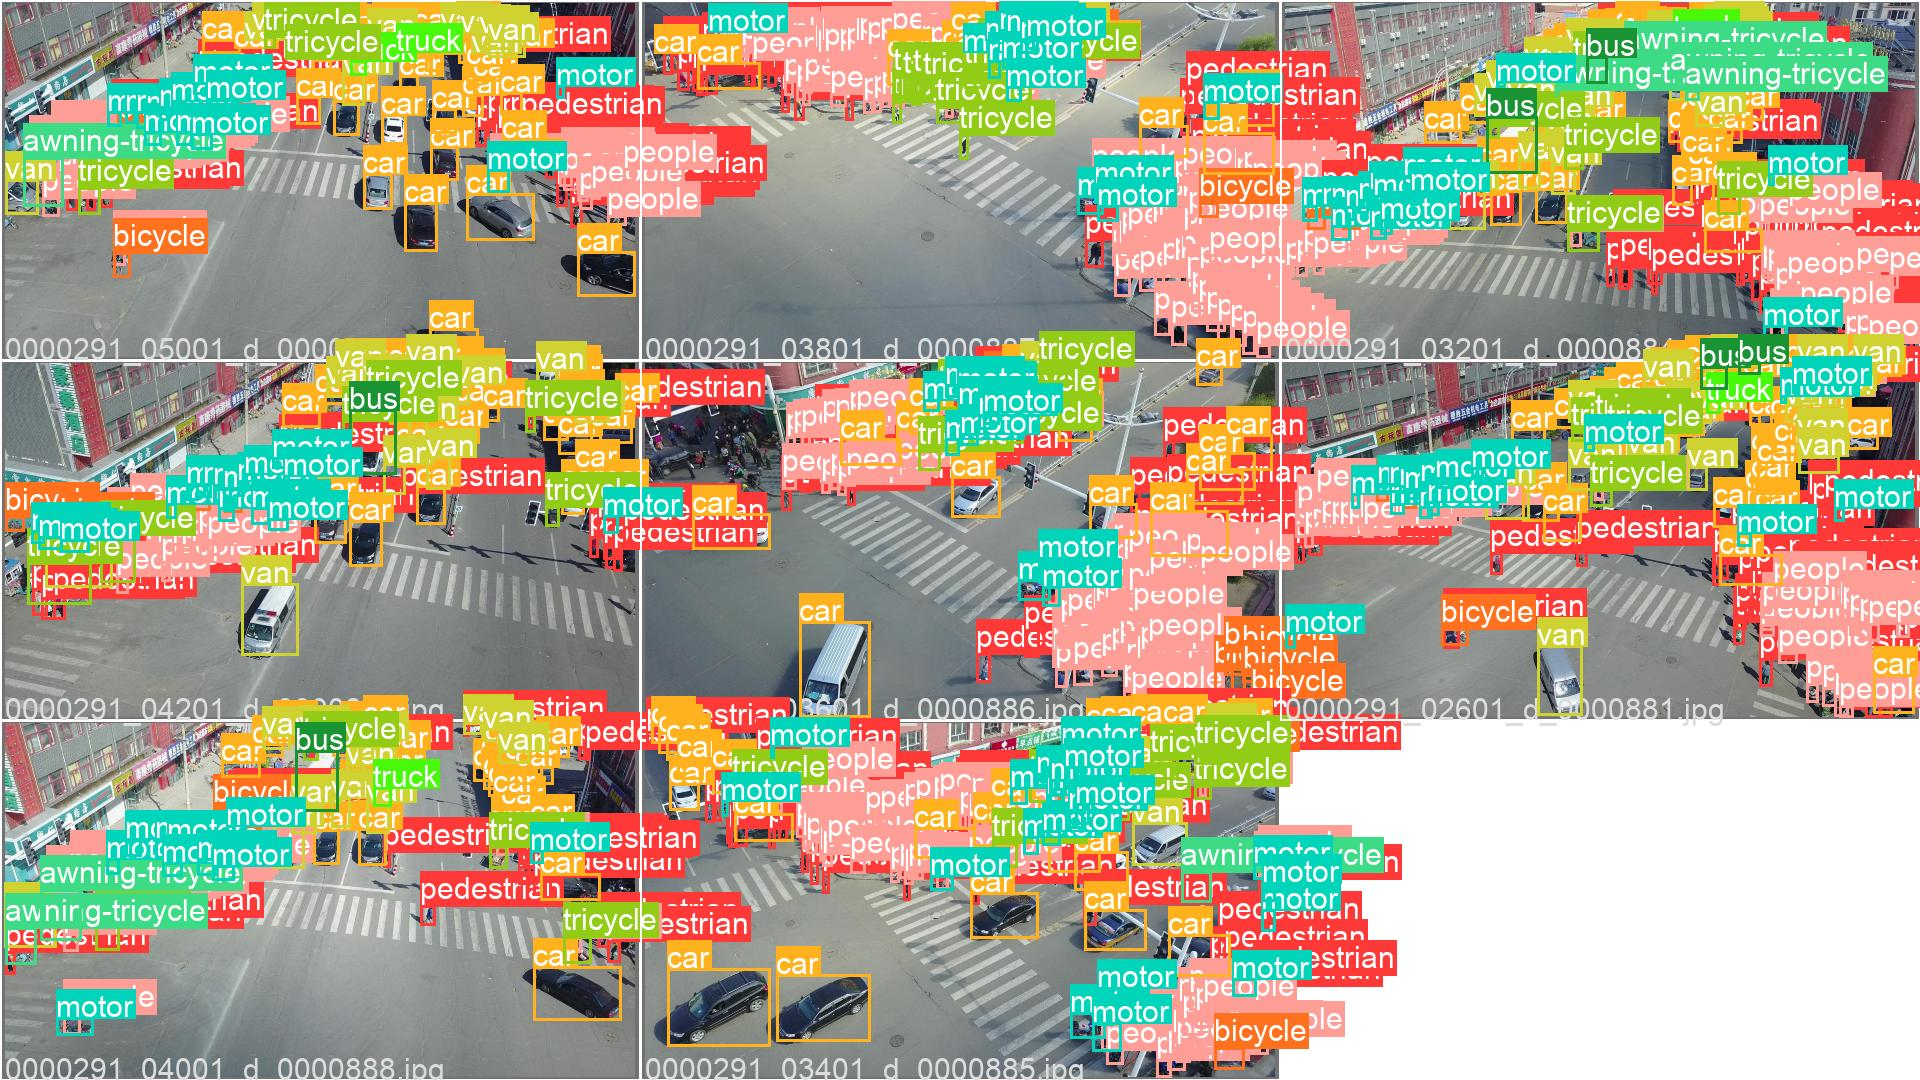

predictions:

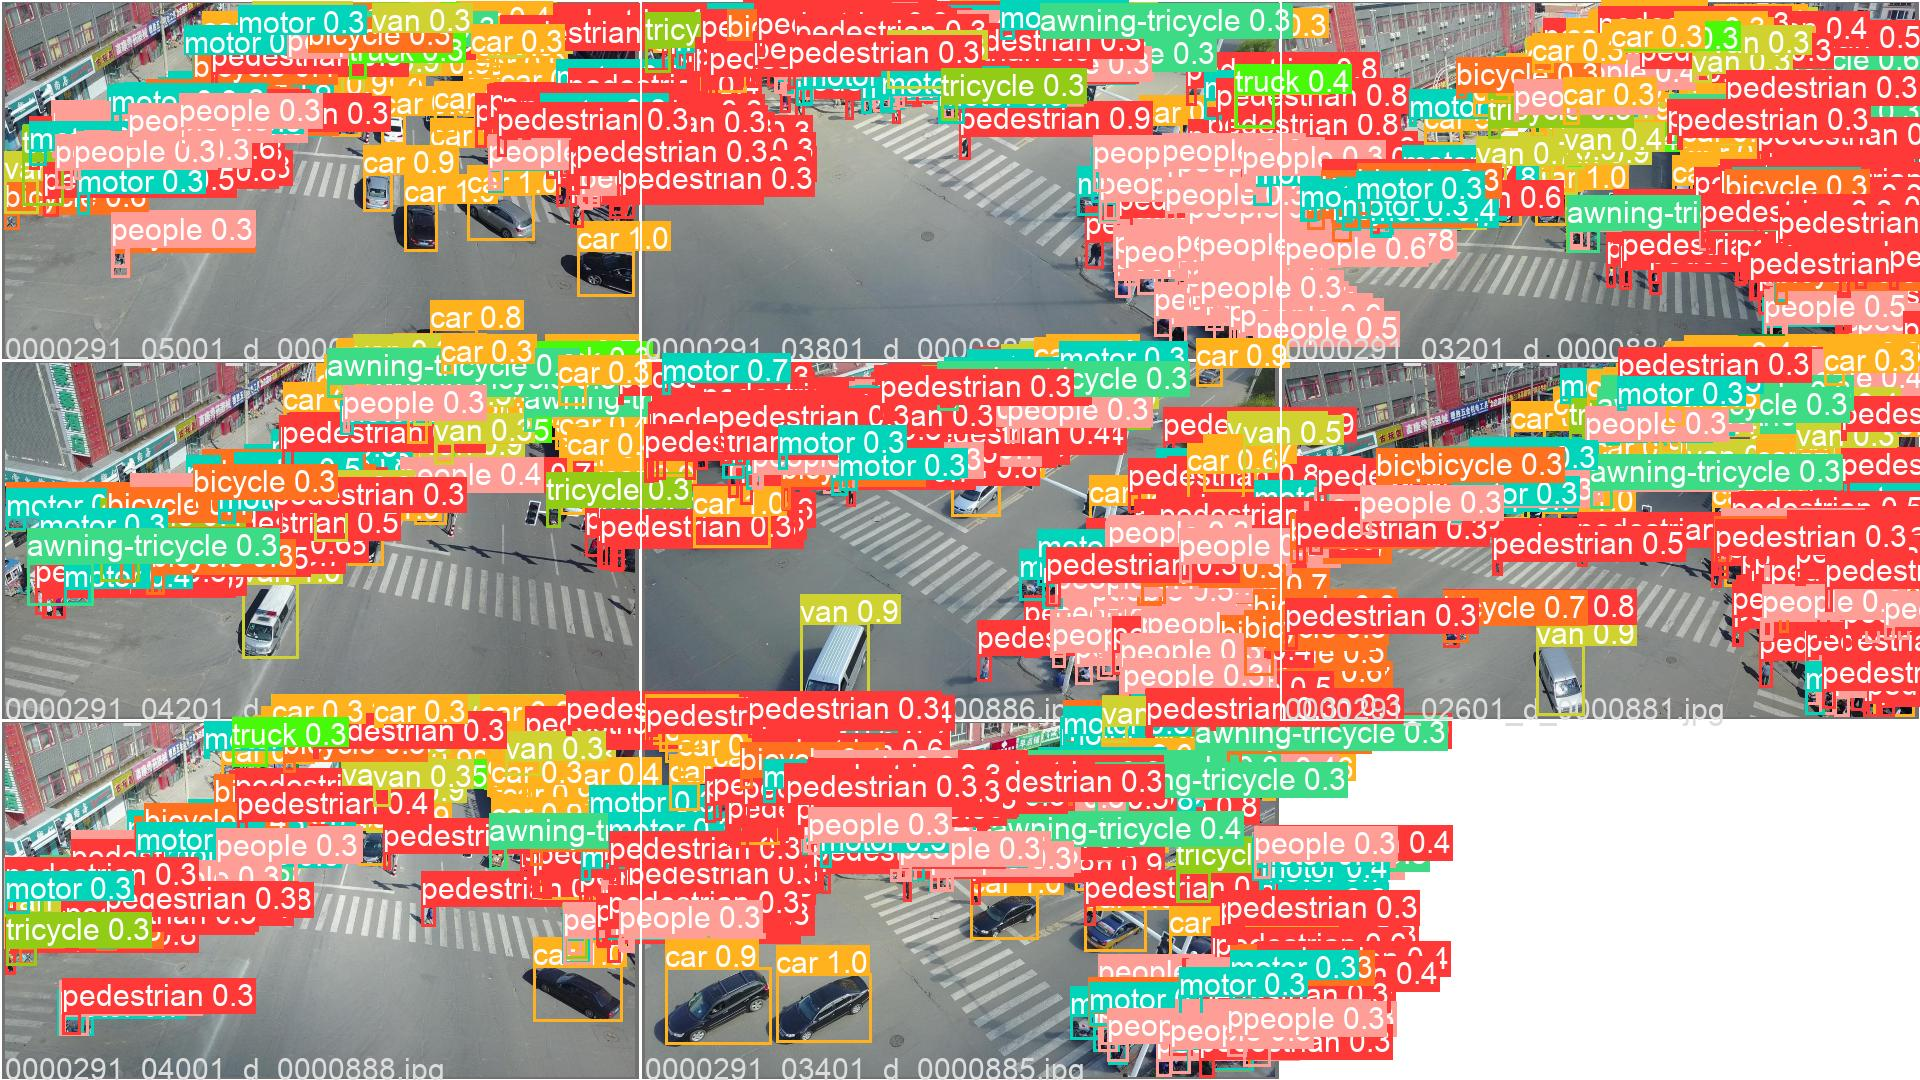

### mAP values for all classes and indivisual classes using 2 weights from training the model

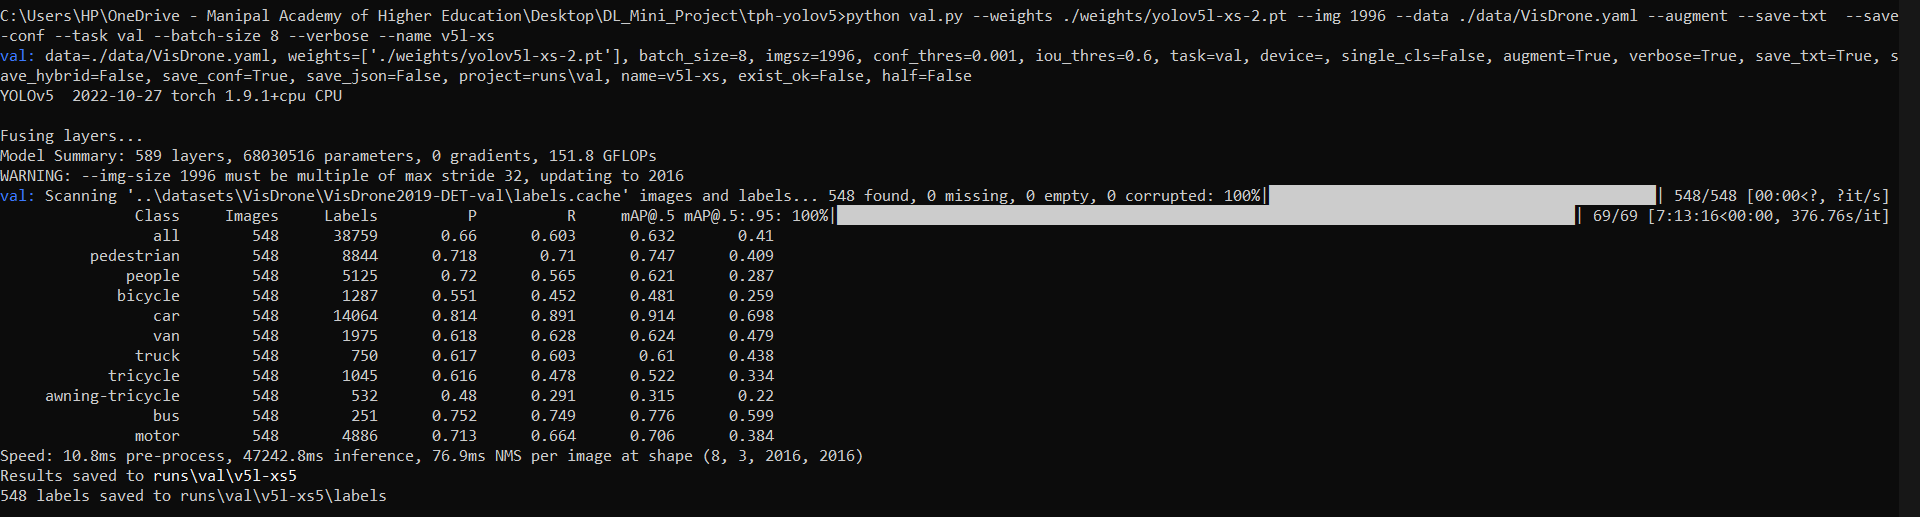

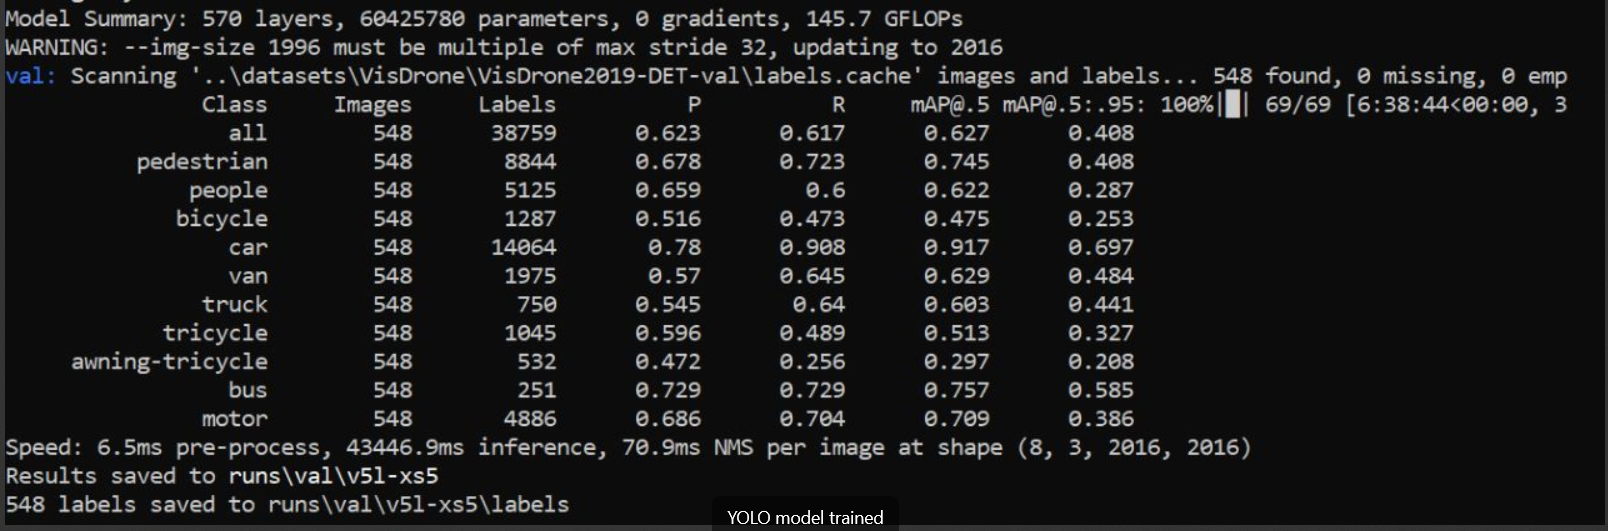

Conclusion:

 Extensive experiments on dataset VisDrone2019 shows that TPH-*YOLOv5 have good performance with impressive interpretability on drone-captured scenarios*. On DET-test-challenge dataset, the AP result of TPH-YOLOv5 are 39.18%, which is better than previous SOTA method (DPNetV3) by 1.81%. On VisDrone Challenge 2021, TPHYOLOv5 wins 5th place and achieves well-matched results with 1st place model (AP 39.43%). Compared to baseline model (YOLOv5), TPH-YOLOv5 improves about 7%, which is encouraging and competitive.